In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
words=open('names.txt','r').read().splitlines()

In [4]:
#从文件中整理出字符集合
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
#生成训练字符集
block_size=3

def build_dataset(words):
  X,Y=[],[]
  for w in words:
    
  
    context=[0]*block_size
    for ch in w+'.':
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
     
        context=context[1:] + [ix]
  X=torch.tensor(X)
  Y=torch.tensor(Y)
  print(X.shape)       
  return X,Y
     
import random
random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr =build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])


torch.Size([182625, 3])
torch.Size([22655, 3])
torch.Size([22866, 3])


In [6]:
#初始化高斯分布
n_embd=10
n_hidden=200

g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embd),          generator=g)
W1=torch.randn((n_embd*block_size,n_hidden),generator=g)*(5/3)/((n_embd*block_size)**0.5)
b1=torch.randn(n_hidden,                   generator=g)*0.01
W2=torch.randn((n_hidden,vocab_size),       generator=g)*0.01
b2=torch.randn(vocab_size,                  generator=g)*0

bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))
bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))
parameters=[C,W1,b1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
     p.requires_grad=True


12297


In [7]:
#训练得出loss值
max_steps=200000
batch_size=32
lossi=[]

for i in range(max_steps):
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix]
#向前传递
    emb=C[Xb]
    embcat=emb.view(emb.shape[0],-1)

#线性层
    hpreact=embcat@W1+b1
#标准化层
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact=bngain *(hpreact-bnmeani)/bnstdi

    with torch.no_grad():
      bnmean_running=0.999*bnmean_running/bnstdi+bnbias
      bnstd_running=0.999*bnstd_running/bnstdi+bnbias
#非线性层
    h=torch.tanh(hpreact)
    logits=h @ W2 + b2
    loss=F.cross_entropy(logits,Yb)

    for p in parameters:
       p.grad = None
    loss.backward()

    lr =0.1 if i<100000 else 0.01
    for p in parameters:
        if p.grad is not None:
           p.data += -lr * p.grad
      

    if i%10000 == 0:
      print(f':{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
     

:      0/ 200000:3.3147
:  10000/ 200000:2.1921
:  20000/ 200000:2.3627
:  30000/ 200000:2.4109
:  40000/ 200000:2.0274
:  50000/ 200000:2.2800
:  60000/ 200000:2.5122
:  70000/ 200000:2.0855
:  80000/ 200000:2.2819
:  90000/ 200000:2.1440
: 100000/ 200000:1.9832
: 110000/ 200000:2.3336
: 120000/ 200000:1.9038
: 130000/ 200000:2.4069
: 140000/ 200000:2.4566
: 150000/ 200000:2.2161
: 160000/ 200000:2.0107
: 170000/ 200000:1.9093
: 180000/ 200000:2.0212
: 190000/ 200000:1.8881


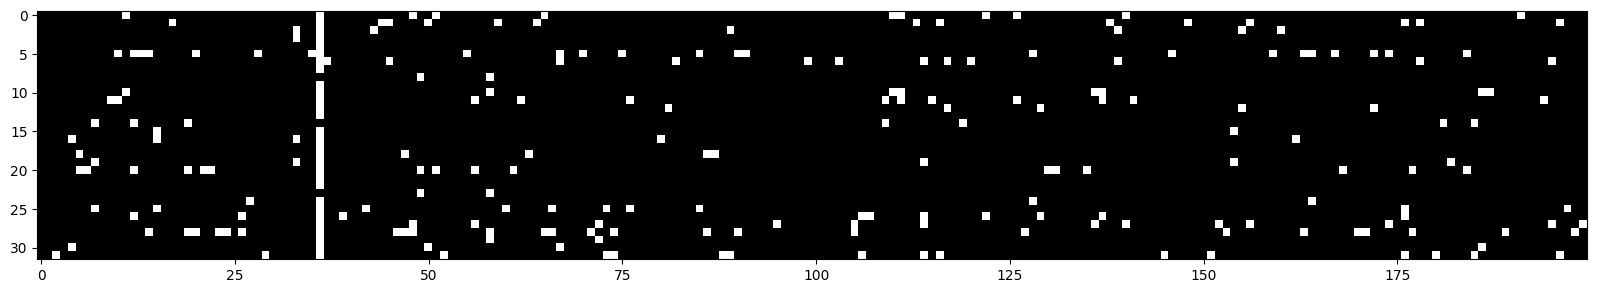

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

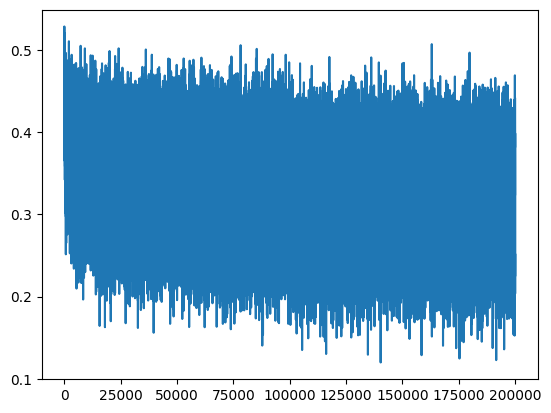

In [9]:
plt.plot(lossi)

In [10]:
#评估loss

@torch.no_grad()
def split_loss(split):
  x,y ={
    'train':(Xtr,Ytr),
    'val':(Xdev,Ydev),
    'test':(Xte,Yte),
}[split]
  emb =C[x]
  embcat=emb.view(emb.shape[0],-1)
  h= torch.tanh(embcat @W1+b1)
  logits=h@W2+b2
  loss=F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.626187801361084
val 2.659747362136841


In [11]:
#训练生产名字结果
g = torch.Generator().manual_seed(2147483647 +10)

for _ in range(20):

    out=[]
    context = [0]*block_size
    while True:
      emb =C[torch.tensor([context])]
      h=torch.tanh(emb.view(1,-1) @ W1 + b1)
      logits =h@W2+b2
      probs=F.softmax(logits,dim=1)
      ix = torch.multinomial(probs,num_samples=1,generator=g).item()
      context=context[1:]+[ix]
      out.append(ix)

      if ix ==0:
        break
    print(''.join(itos[i] for i in out))                   
        

mrikahmyah.
selvend.
fran.
tevarngeld.
leg.
siched.
teh.
jengvakirstel.
varraarvelyzirsthal.
nyshubrigh.
dayvia.
jadreth.
shanthucks.
brayvdarkyshufmelgh.
majahshmyah.
hil.
sakyansunnyck.
lvourni.
try.
nughaisley.


(array([50.,  7.,  3.,  3.,  4.,  5.,  4.,  1.,  2.,  1.,  3.,  2.,  0.,
         3.,  1.,  0.,  1.,  2.,  1.,  0.,  2.,  1.,  3.,  0.,  1.,  2.,
         2.,  2.,  0.,  0.,  1.,  0.,  2.,  2.,  2.,  1.,  1.,  1.,  3.,
         2.,  2.,  0.,  2.,  1.,  2.,  3.,  6.,  7.,  7., 49.]),
 array([-9.99994040e-01, -9.59994160e-01, -9.19994280e-01, -8.79994401e-01,
        -8.39994521e-01, -7.99994642e-01, -7.59994762e-01, -7.19994882e-01,
        -6.79995003e-01, -6.39995123e-01, -5.99995244e-01, -5.59995364e-01,
        -5.19995484e-01, -4.79995605e-01, -4.39995725e-01, -3.99995846e-01,
        -3.59995966e-01, -3.19996086e-01, -2.79996207e-01, -2.39996327e-01,
        -1.99996448e-01, -1.59996568e-01, -1.19996688e-01, -7.99968088e-02,
        -3.99969292e-02,  2.95042992e-06,  4.00028300e-02,  8.00027096e-02,
         1.20002589e-01,  1.60002469e-01,  2.00002348e-01,  2.40002228e-01,
         2.80002108e-01,  3.20001987e-01,  3.60001867e-01,  4.00001746e-01,
         4.40001626e-01,  4.8000

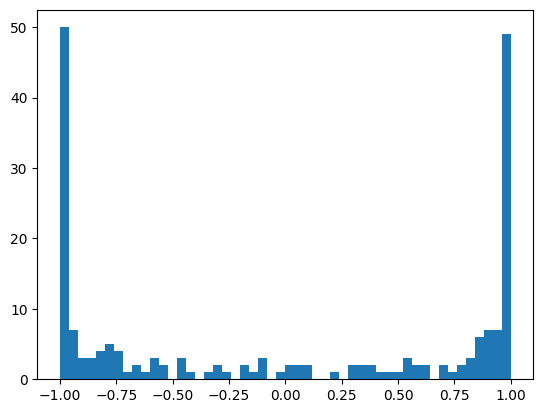

In [12]:
plt.hist(h.view(-1).tolist(),50)

(array([  5.,   0.,   0.,   0.,   0.,   4.,   4.,   4.,   4.,  11.,  21.,
         28.,  33.,  62.,  87., 118., 129., 139., 183., 241., 362., 390.,
        377., 532., 575., 576., 459., 415., 344., 307., 255., 169., 145.,
        117.,  95.,  68.,  41.,  27.,  17.,  12.,  12.,  16.,   3.,   6.,
          2.,   1.,   1.,   1.,   0.,   2.]),
 array([-5.6998868 , -5.47002485, -5.24016291, -5.01030096, -4.78043901,
        -4.55057707, -4.32071512, -4.09085318, -3.86099123, -3.63112928,
        -3.40126734, -3.17140539, -2.94154345, -2.7116815 , -2.48181955,
        -2.25195761, -2.02209566, -1.79223372, -1.56237177, -1.33250982,
        -1.10264788, -0.87278593, -0.64292398, -0.41306204, -0.18320009,
         0.04666185,  0.2765238 ,  0.50638575,  0.73624769,  0.96610964,
         1.19597158,  1.42583353,  1.65569548,  1.88555742,  2.11541937,
         2.34528131,  2.57514326,  2.80500521,  3.03486715,  3.2647291 ,
         3.49459105,  3.72445299,  3.95431494,  4.18417688,  4.41403883,
 

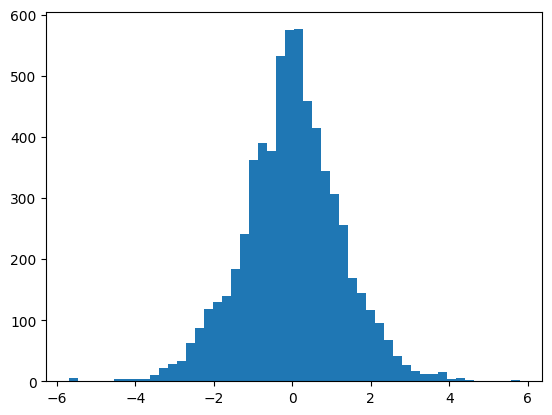

In [13]:
plt.hist(hpreact.view(-1).tolist(),50)

In [14]:
#线性
class Linear:

    def __init__(self,fan_in,fan_out,bias=True):
       self.weight=torch.randn((fan_in,fan_out),generator=g)/fan_in**0.5  #权重
       self.bias=torch.zeros(fan_out) if bias else None                   #偏差
    def __call__(self,x):
        self.out=x@self.weight
        if self.bias is not None:
          self.out+=self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

#批量标准化线性层

class BatchNormld:

    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps
        self.momentum=momentum
        self.training=True
        self.gamma=torch.ones(dim) 
        self.beta=torch.zeros(dim) 
        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)

    def __call__(self,x):
        
         if self.training:
             xmean=x.mean(0,keepdim=True) #均值
             xvar=x.var(0,keepdim=True) #方差
         else:
             xmean =self.running_mean
             xvar=self.running_var
         xhat=(x-xmean)/torch.sqrt(xvar+self.eps)#数据标准化
         self.out=self.gamma*xhat+self.beta
       #更新模型运行均值和方差
         if self.training:
             with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean+self.momentum*xmean
                self.running_var=(1-self.momentum)*self.running_var+self.momentum*xvar
             return self.out
       #模型参数
    def parameters(self):
          
          return[self.gamma,self.beta]
#非线性层
class Tanh:
    
    def __call__(self,x):
      self.out=torch.tanh(x)
      return self.out
    def parameters(self):
        return[]

n_embd=10#字符向量嵌入维度
n_hidden=100 #多层感知器中隐藏层中的数量
g=torch.Generator().manual_seed(2147483647)

C=torch.randn((vocab_size,n_embd),  generator=g)
layers=[
    Linear(n_embd*block_size,n_hidden),Tanh(),
    Linear(         n_hidden,n_hidden),Tanh(),
    Linear(         n_hidden,n_hidden),Tanh(),
    Linear(         n_hidden,n_hidden),Tanh(),
    Linear(         n_hidden,n_hidden),Tanh(),
    Linear(         n_hidden,vocab_size),
]

with torch.no_grad():
    layers[-1].weight*=0.1
    for layer in layers[:-1]:
        if isinstance (layer,Linear):
            layer.weight*=1#5/3

parameters=[C]+[p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True





       
    

46497


In [15]:

max_steps=200000
batch_size=32
lossa=[]
ud=[]

for i in range(max_steps):
    
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=Xtr[ix],Ytr[ix]
#向前传递
    emb=C[Xb]
    x=emb.view(emb.shape[0],-1)
    for layer in layers:
        x=layer(x)
    loss = F.cross_entropy(x,Yb)#损失函数
    for layer in layers:
      layer.out.retain_grad()
    for p in parameters:
       p.grad = None
    loss.backward()

    lr =0.1 if i<100000 else 0.01 #速率
    for p in parameters:
        if p.grad is not None:
           p.data += -lr * p.grad
      

    if i%10000 == 0:
      print(f':{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossa.append(loss.log10().item())   
    with torch.no_grad():
       ud.append([(lr*p.grad.std()/p.data.std()).log().item() for p in parameters])
    


:      0/ 200000:3.2988
:  10000/ 200000:2.4166
:  20000/ 200000:1.9858
:  30000/ 200000:1.8864
:  40000/ 200000:2.0440
:  50000/ 200000:2.1292
:  60000/ 200000:1.7569
:  70000/ 200000:2.0789
:  80000/ 200000:2.3975
:  90000/ 200000:1.8139
: 100000/ 200000:2.3710
: 110000/ 200000:2.1877
: 120000/ 200000:2.0265
: 130000/ 200000:1.9490
: 140000/ 200000:1.7206
: 150000/ 200000:1.7867
: 160000/ 200000:1.8763
: 170000/ 200000:1.8061
: 180000/ 200000:2.1495
: 190000/ 200000:1.8425


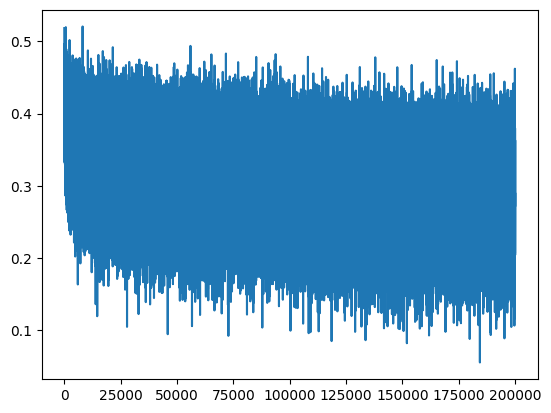

In [16]:
plt.plot(lossa)

layer1(      Tanh):mean-0.03,std0.84,saturated:41.28%
layer3(      Tanh):mean+0.00,std0.88,saturated:50.63%
layer5(      Tanh):mean-0.01,std0.89,saturated:51.94%
layer7(      Tanh):mean-0.02,std0.90,saturated:51.59%
layer9(      Tanh):mean-0.00,std0.73,saturated:25.81%


Text(0.5, 1.0, 'activation distribution')

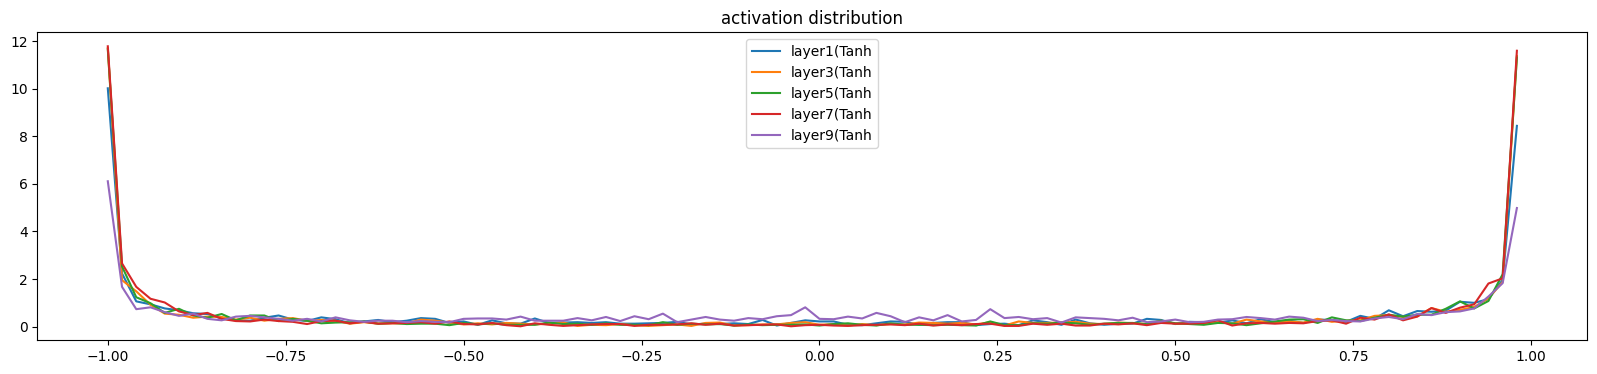

In [17]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]):
   if isinstance(layer,Tanh):
     t=layer.out
     print('layer%d(%10s):mean%+.2f,std%.2f,saturated:%.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))

     hy,hx=torch.histogram(t,density=True)
     plt.plot(hx[:-1].detach(),hy.detach())
     legends.append(f'layer{i}({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
    

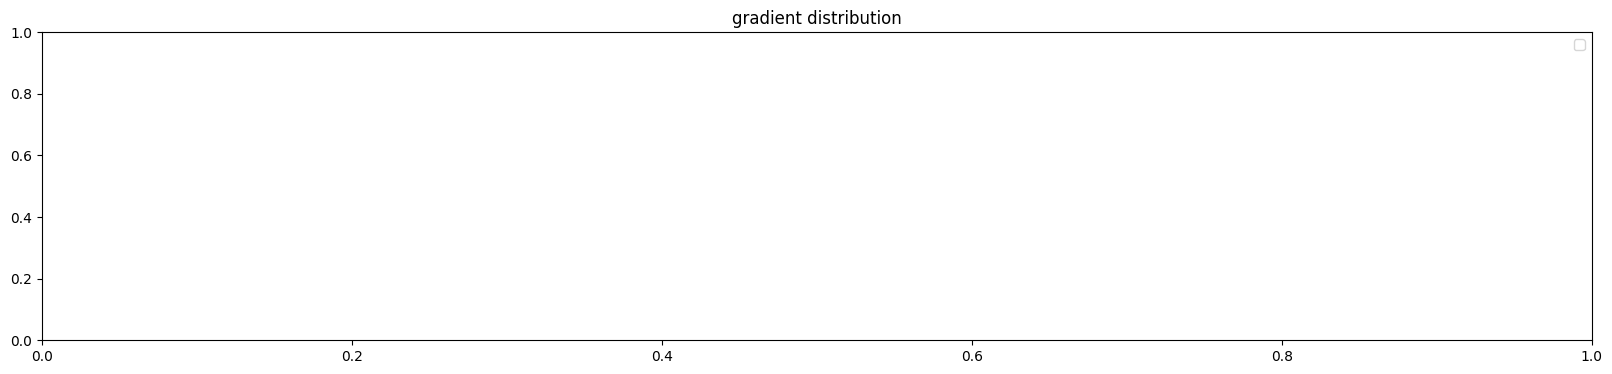

In [19]:
plt.figure(figsize=(20,4))

legends=[]
for i,layer in enumerate(layers[:1]):
    if isinstance (layer,Tanh):
      t =layer.out.grad
      print('layer%d(%10s):mean%+f,std%e'%(i,layer.__class__.__name__,t.mean(),t.std(),t.std()/p.std()))
      hy,hx=torch.histogram(t,density=True)
      plt.plot(hx[:-1].detach(),hy.detach())
      legends.append(f'layer{i}({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution');


weight  (27, 10) | mean +0.000539| std2.154972e-02| grad :data ratio 1.733277e-02
weight (30, 100) | mean +0.000177| std1.028600e-02| grad :data ratio 1.783562e-02
weight(100, 100) | mean -0.000002| std5.376220e-03| grad :data ratio 1.564565e-02
weight(100, 100) | mean -0.000100| std6.353390e-03| grad :data ratio 1.929129e-02
weight(100, 100) | mean -0.000034| std6.513390e-03| grad :data ratio 2.045800e-02
weight(100, 100) | mean -0.000008| std7.739588e-03| grad :data ratio 3.130746e-02
weight (100, 27) | mean +0.000000| std2.150428e-02| grad :data ratio 1.004362e-01


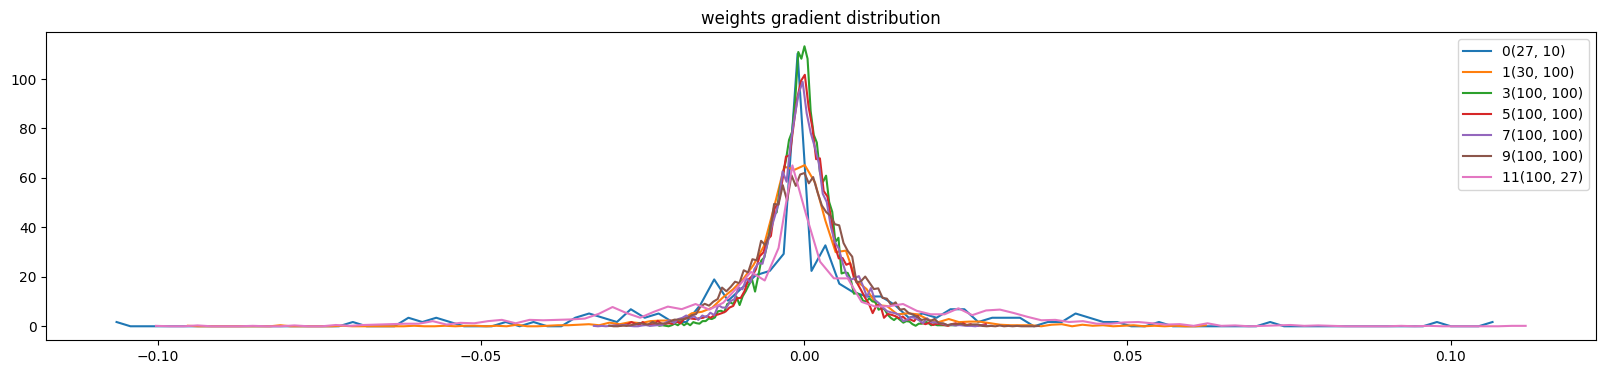

In [80]:
plt.figure(figsize=(20,4))
legends=[]
for i,p in enumerate(parameters):
   t=p.grad
   if p.ndim==2:
    print('weight%10s | mean %+f| std%e| grad :data ratio %e'%(tuple(p.shape),t.mean(),t.std(),t.std()/p.std()))
    hy,hx=torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(),hy.detach())
    legends.append(f'{i}{tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weights gradient distribution');

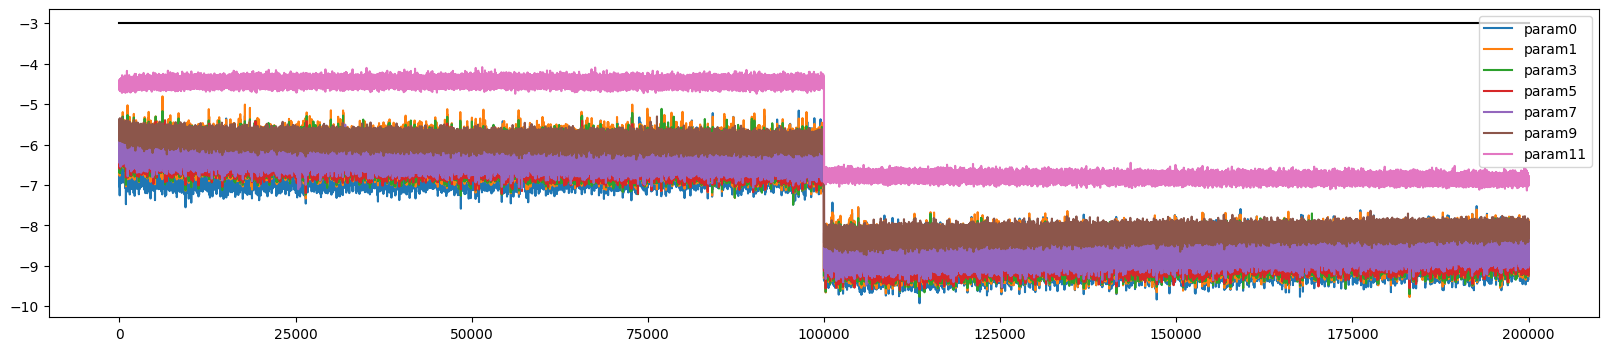

In [81]:
plt.figure(figsize=(20,4))
legends=[]
for i,p in enumerate(parameters):
  if p.ndim==2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param%d'%i)
plt.plot([0,len(ud)],[-3,-3],'k')
plt.legend(legends);

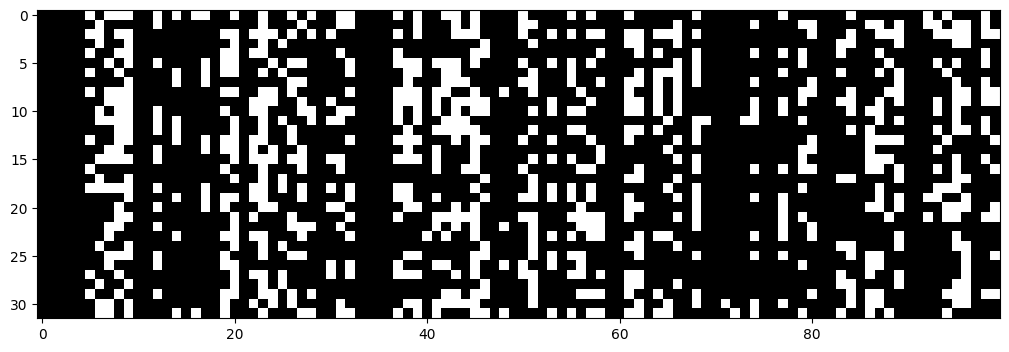

In [82]:
plt.figure(figsize=(20,4))
for i,layer in enumerate(layers[:-1]):
   if isinstance(layer,Tanh):
     t=layer.out
plt.imshow(t.abs()>0.99,cmap='gray',interpolation='nearest')

In [95]:
@torch.no_grad()
def split_loss(split):
  x,y ={
    'train':(Xtr,Ytr),
    'val':(Xdev,Ydev),
    'test':(Xte,Yte),
}[split]
  emb=C[Xb]

  x=emb.view(emb.shape[0],-1)
  for layer in layers:
    x=layer(x)
    loss = F.cross_entropy(x,Yb)#损失函数
    print(split,loss.item())

split_loss('train')
split_loss('val')


train 10.436994552612305
train 5.178305149078369
train 10.84366226196289
train 4.928724765777588
train 11.871922492980957
train 5.280196666717529
train 10.090588569641113
train 4.843539714813232
train 8.183921813964844
train 4.7664103507995605
train 1.8490386009216309
val 10.436994552612305
val 5.178305149078369
val 10.84366226196289
val 4.928724765777588
val 11.871922492980957
val 5.280196666717529
val 10.090588569641113
val 4.843539714813232
val 8.183921813964844
val 4.7664103507995605
val 1.8490386009216309


In [ ]:
g = torch.Generator().manual_seed(2147483647 +10)

for _ in range(20):

    out=[]
    context = [0]*block_size
    while True:
      emb =C[torch.tensor([context])]
      x=emb.view(1,-1)
      for layer in layers:
        x=layer(x)
    loss = F.cross_entropy(x,Yb)#损失函数
        
      h=torch.tanh(emb.view(1,-1) @ W1 + b1)
      logits =h@W2+b2
      probs=F.softmax(logits,dim=1)
      ix = torch.multinomial(probs,num_samples=1,generator=g).item()
      context=context[1:]+[ix]
      out.append(ix)

      if ix ==0:
        break
    print(''.join(itos[i] for i in out))                   
        